In [166]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [167]:
def f(x):
    return 3*x**2 - 4*x + 5

In [168]:
f(3.0)

20.0

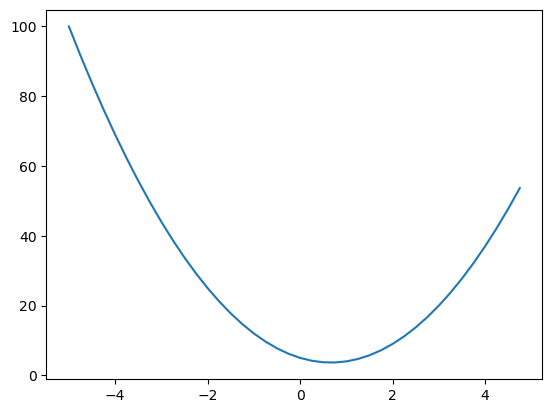

In [169]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [170]:
h = 0.00001
x = 2/3
(f(x + h) - f(x))/h

3.0000002482211127e-05

In [171]:
# more complex function, with 3 scalar inputs
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [172]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0
d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [173]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self) -> str:
        return f"Value(data = {self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+', '')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out
    
    def __radd__(self, other): # other + self
        return self + other;

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)        
        out = Value(self.data * other.data, (self, other), '*', '')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
    
    def __rmul__(self, other): # other * self
        return self * other
    
    def __pow__(self, other): # self ** other
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self, ), f'**{other}')
        
        def _backward():
            self.grad += other * self.data ** (other - 1) * out.grad # other * self.data**(other - 1)
        out._backward = _backward
        
        return out
    
    def __truediv__(self, other): # self / other
        return self * other**-1
    
    def __neg__(self): # -self
        return self * -1
    
    def __sub__(self, other): # self - other
        return self + (-other)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh', '')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out
    
    def backward(self):
        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


In [174]:
a = Value(2)
b = Value(4)
a - b

Value(data = -2)

In [175]:
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'

In [176]:
import graphviz

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = graphviz.Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

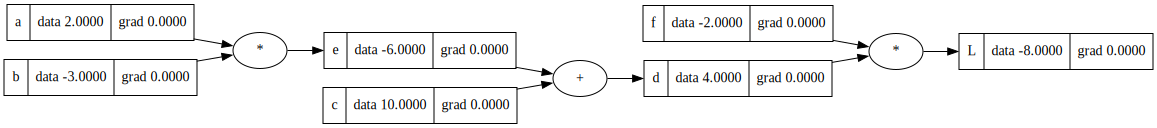

In [177]:
draw_dot(L)

In [178]:
L.grad = 1
f.grad = 4
d.grad = -2

derivative chain rule:
dL/dc = dL/dd * dd/dc

d = e + c
dc/dd = ((e+(c+h)) - (e+c)/h
dc/dd = (e + c + h - e - c)/h = h / h = 1

same for e

dL/dc =  dL/dd * dd/dc = -2 * 1 = -2
dL/dd = dL/dd * dd/de = -2 * 1 = -2

In [179]:
c.grad = -2
e.grad = -2

dL/da = de/da * dd/de * dL/dd = de/da * dL/de = b * dL/de = -3 * -2 = 6
dL/db = de/db * dd/de * dL/dd = de/db * dL/de = a * dL/de = 2 * -2 = -4


In [180]:
a.grad = 6
b.grad = -4

In [181]:
def lol():
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data
    
    h = 0.001
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    b.data += h
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    d.data
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data
    
    grad = (L2 - L1)/h
    print(grad)
lol()

-3.9999999999995595


In [182]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * d.grad

e = a*b
d = e + c
L = d * f

print(L.data)

-7.509552


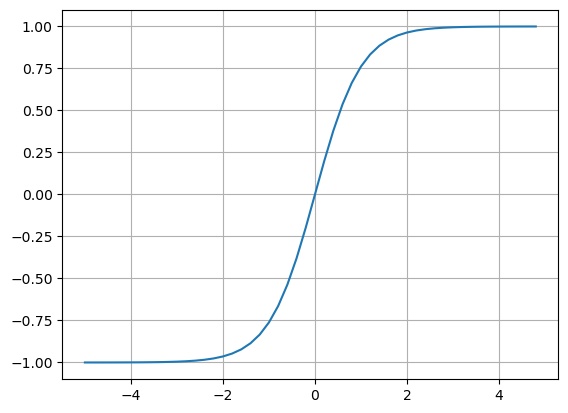

In [183]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid()

In [184]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2= Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x1*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

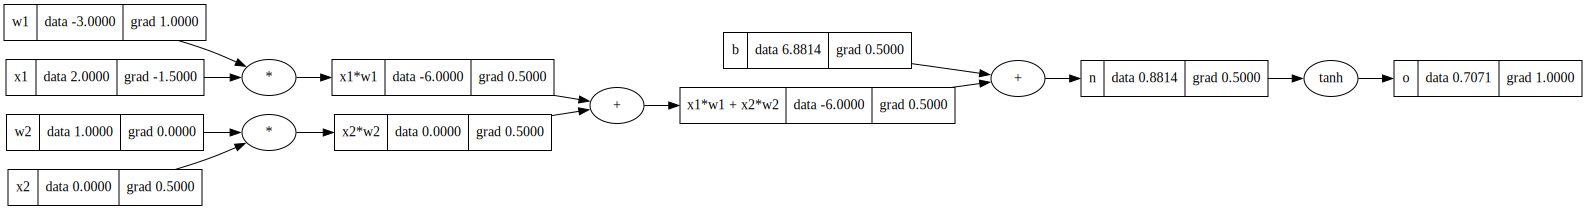

In [185]:
draw_dot(o)

In [186]:
o.backward()

In [187]:
o.grad = 1

In [188]:
o._backward()

In [189]:
n._backward()

In [190]:
b._backward()

In [191]:
x1w1x2w2._backward()

In [192]:
x1w1._backward()
x2w2._backward()

In [193]:
w2.grad = x2.data * x2w2.grad
x2.grad = w2.data * x2w2.grad

In [194]:
w1.grad = x1.data * x1w1.grad
x1.grad = w1.data * x1w1.grad

In [195]:
x1w1.grad = 0.5
x2w2.grad = 0.5

In [196]:
x1w1x2w2.grad = 0.5
b.grad = 0.5

In [197]:
n.grad = 0.5

In [198]:
o.grad = 1

In [199]:
# o = tanh(n)
# do/dn = 1 - tanh(n)^2 = 1 - o^2

In [200]:
1 - o.data**2

0.4999999999999999

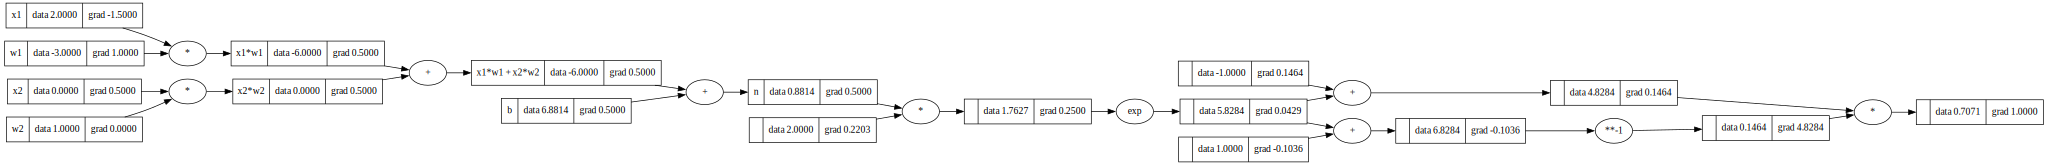

In [201]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2= Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x1*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ---
e = (2*n).exp()
o = (e - 1) / (e + 1)
o.backward()
draw_dot(o)

In [202]:
import torch 

In [203]:


x1 = torch.Tensor([2.0]). double()              ; x1.requires_grad = True
x2 = torch.Tensor([0.0]). double()              ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]). double()              ; w1.requires_grad = True
w2 = torch.Tensor([1.0]). double()              ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]). double()              ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('----')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
----
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [204]:
torch.Tensor([[1,2,3],[4,5,6]]).shape

torch.Size([2, 3])

In [205]:
x2.grad

tensor([0.5000], dtype=torch.float64)

In [206]:
import random

In [242]:
class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        
    def parameters(self):
        return self.w + [self.b]
    
    def __call__(self, x):
        # w * x + b where w * x is dot product of w and x
#         print(list(zip(self.w, x)))
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
class Layer:
    
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

class MLP:
    
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]



In [245]:
len(n.parameters())

41

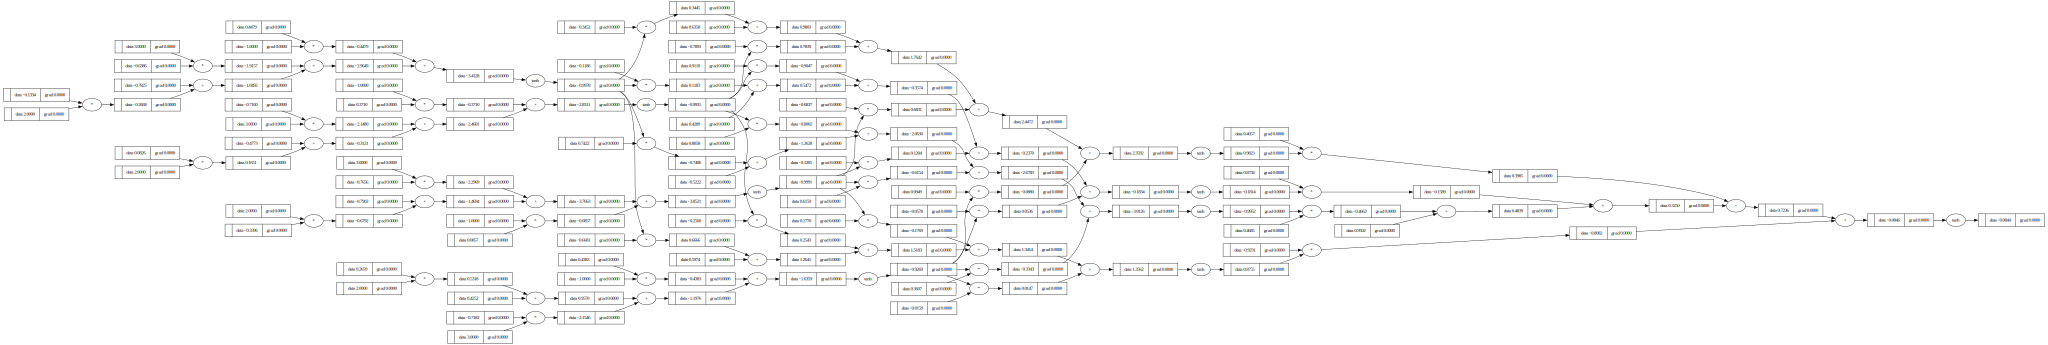

In [246]:
draw_dot(n(x))

In [253]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data = 7.073709358809529)

In [254]:
loss.backward()

In [255]:
n.layers[0].neurons[0].w[0]

Value(data = -0.13339516099526394)

In [256]:
n.layers[0].neurons[0].w[0].grad

1.7570604323248673

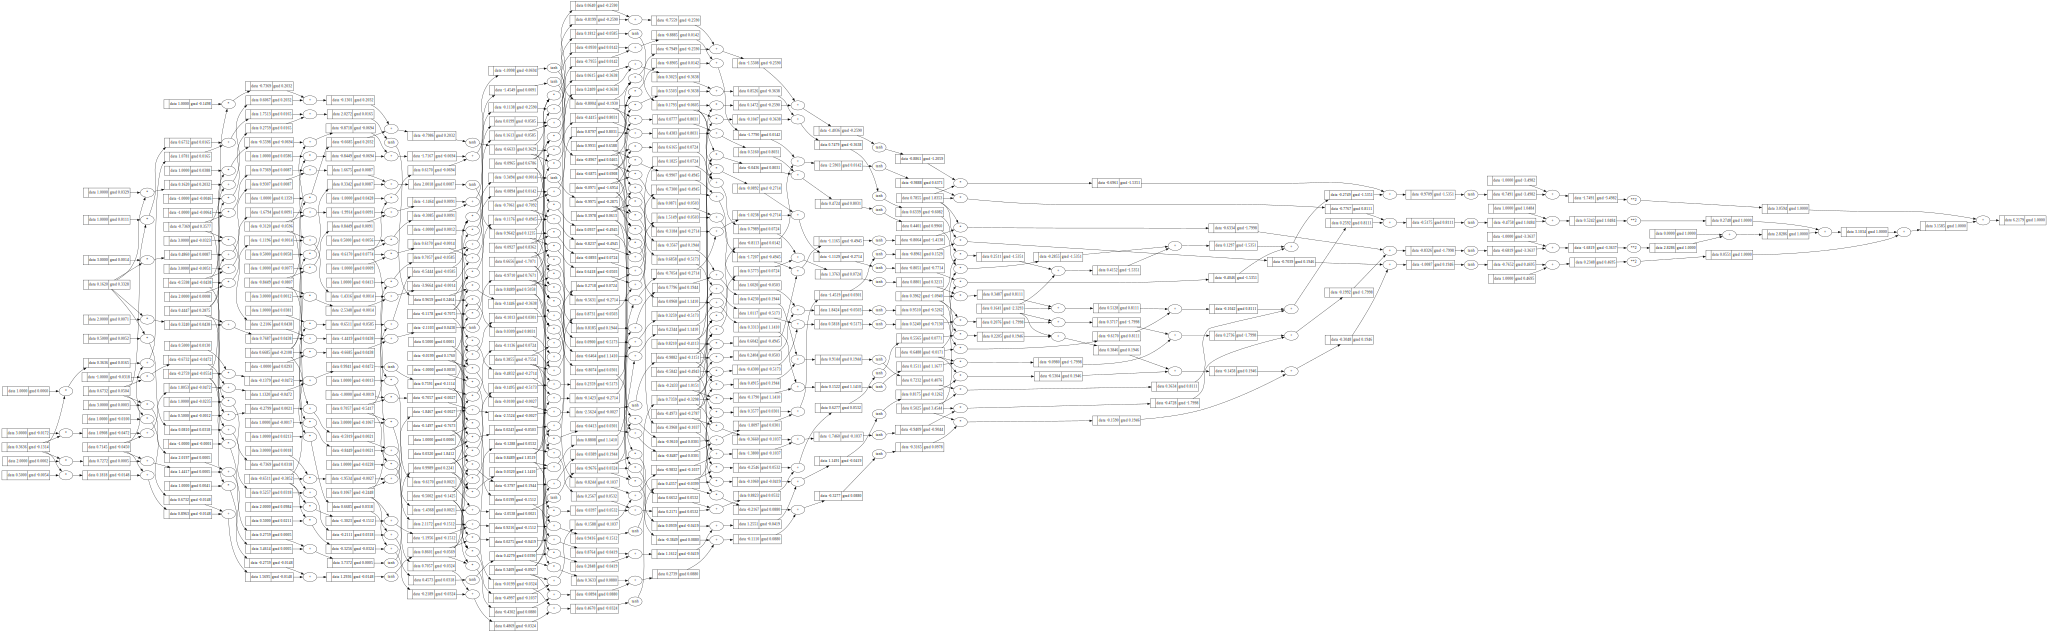

In [229]:
draw_dot(loss)

In [259]:
n.layers[0].neurons[0].w[0].grad

1.7570604323248673

In [262]:
n.layers[0].neurons[0].w[0]

Value(data = -0.1509657653185126)

In [383]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data = 0.12033104258783323)

In [402]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [409]:

for k in range(20):
    
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    
    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    
    # update (gradient descent)
    for p in n.parameters():
        p.data += -0.05 * p.grad
        
    print(k, loss.data)

0 0.0038442343151475437
1 0.0038251386077311953
2 0.003806224653739813
3 0.003787489906309934
4 0.003768931865588212
5 0.0037505480776567346
6 0.0037323361334877653
7 0.0037142936679266363
8 0.00369641835870216
9 0.0036787079254635546
10 0.003661160128843362
11 0.003643772769544866
12 0.0036265436874541902
13 0.003609470760775467
14 0.003592551905189003
15 0.003575785073031238
16 0.003559168252496218
17 0.003542699466857799
18 0.0035263767737118623
19 0.0035101982642380142


In [410]:
ypred

[Value(data = 0.9808556671035926),
 Value(data = -0.962511579434226),
 Value(data = -0.9770515656795085),
 Value(data = 0.96519079909117)]